In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.model_selection import GroupKFold
from PIL import Image
from tqdm import tqdm  # <--- NEW IMPORT

# --- 1. CONFIGURATION ---
PROCESSED_DATA_DIR = "../content/processed_data"  # Check this path matches your machine
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 3
K_FOLDS = 5
TARGET_SIZE = (224, 224)

# --- 2. DATASET ---
class NeuroDataset(Dataset):
    def __init__(self, root_dir, file_list, transform=None):
        self.root_dir = root_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        rel_path, label = self.file_list[idx]
        img_path = os.path.join(self.root_dir, rel_path)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            image = Image.new('RGB', TARGET_SIZE)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Augmentations
train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 3. MODEL ---
def get_model():
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(CLASSES))
    return model.to(DEVICE)

# --- 4. TRAINING WITH PROGRESS BAR ---
def train_full_pipeline():
    # A. Gather files
    all_files = [] 
    groups = []
    
    print("📂 Scanning processed files...")
    for label_idx, cls in enumerate(CLASSES):
        cls_dir = os.path.join(PROCESSED_DATA_DIR, cls)
        if not os.path.exists(cls_dir): continue
            
        fnames = os.listdir(cls_dir)
        for f in fnames:
            if not f.lower().endswith(('.jpg', '.png', '.jpeg')): continue
            pid = f.split('_')[0] 
            all_files.append((os.path.join(cls, f), label_idx))
            groups.append(pid)

    # B. Setup Cross-Validation
    gkf = GroupKFold(n_splits=K_FOLDS)
    history = []
    
    # Dummy arrays for splitter
    X_dummy = np.zeros(len(all_files))
    y_dummy = [x[1] for x in all_files]
    
    print(f"🚀 Starting Balanced Training on {len(all_files)} images...")

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_dummy, y_dummy, groups=groups)):
        print(f"\n=== FOLD {fold+1}/{K_FOLDS} ===")
        
        # --- Imbalance Fix ---
        train_labels = [y_dummy[i] for i in train_idx]
        class_counts = np.bincount(train_labels)
        class_weights = 1. / class_counts
        sample_weights = [class_weights[l] for l in train_labels]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        # ---------------------

        # Create DataLoaders
        train_data = NeuroDataset(PROCESSED_DATA_DIR, [all_files[i] for i in train_idx], transform=train_transforms)
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler)
        
        val_data = NeuroDataset(PROCESSED_DATA_DIR, [all_files[i] for i in val_idx], transform=val_transforms)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
        
        # Init Model
        model = get_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        
        best_fold_acc = 0.0
        
        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0
            
            # --- NEW: TQDM Progress Bar ---
            # We wrap train_loader with tqdm to create the visual bar
            loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", leave=False)
            
            for images, labels in loop:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                # Update the progress bar with the current loss
                loop.set_postfix(loss=loss.item())
            # ------------------------------
                
            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (preds == labels).sum().item()
            
            val_acc = 100 * correct / total
            print(f"Ep {epoch+1}: Avg Loss {train_loss/len(train_loader):.4f} | Val Acc: {val_acc:.2f}%")
            
            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                torch.save(model.state_dict(), f"resnet_fold{fold+1}.pth")
                
        history.append(best_fold_acc)
        print(f"--> Fold {fold+1} Best: {best_fold_acc:.2f}%")
    
    # --- CREATE ENSEMBLE MODEL (Average Weights) ---
    avg_acc = np.mean(history)
    print(f"\n✅ Training Complete. Avg Acc: {avg_acc:.2f}%")
    print("\n🔄 Creating ensemble model by averaging fold weights...")
    
    # Load all fold models and average their weights
    ensemble_model = get_model()
    ensemble_state_dict = ensemble_model.state_dict()
    
    # Initialize dict to accumulate weights
    for key in ensemble_state_dict.keys():
        ensemble_state_dict[key] = torch.zeros_like(ensemble_state_dict[key], dtype=torch.float32)
    
    # Sum all fold weights
    for fold in range(K_FOLDS):
        fold_path = f"resnet_fold{fold+1}.pth"
        if os.path.exists(fold_path):
            fold_state = torch.load(fold_path, map_location=DEVICE)
            for key in ensemble_state_dict.keys():
                ensemble_state_dict[key] += fold_state[key]
        else:
            print(f"⚠️  Warning: {fold_path} not found, skipping...")
    
    # Average the weights
    for key in ensemble_state_dict.keys():
        ensemble_state_dict[key] = ensemble_state_dict[key] / K_FOLDS
    
    # Save ensemble model with avg accuracy in filename
    ensemble_filename = f"best_resnet_model_avg_{avg_acc:.2f}.pth"
    ensemble_model.load_state_dict(ensemble_state_dict)
    torch.save(ensemble_model.state_dict(), ensemble_filename)
    print(f"✅ Ensemble model saved as: {ensemble_filename}")
    
    return history, avg_acc

# EXECUTE
train_full_pipeline()

📂 Scanning processed files...
🚀 Starting Balanced Training on 311 images...

=== FOLD 1/5 ===


d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ep 1: Avg Loss 0.4573 | Val Acc: 87.30%


Ep 2: Avg Loss 0.0454 | Val Acc: 84.13%


Ep 3: Avg Loss 0.0385 | Val Acc: 84.13%
--> Fold 1 Best: 87.30%

=== FOLD 2/5 ===


Ep 1: Avg Loss 0.4609 | Val Acc: 100.00%


Ep 2: Avg Loss 0.1615 | Val Acc: 88.71%


Ep 3: Avg Loss 0.0569 | Val Acc: 90.32%
--> Fold 2 Best: 100.00%

=== FOLD 3/5 ===


Ep 1: Avg Loss 0.4610 | Val Acc: 95.16%


Ep 2: Avg Loss 0.1409 | Val Acc: 100.00%


Ep 3: Avg Loss 0.0544 | Val Acc: 96.77%
--> Fold 3 Best: 100.00%

=== FOLD 4/5 ===


Ep 1: Avg Loss 0.4793 | Val Acc: 70.97%


Ep 2: Avg Loss 0.1124 | Val Acc: 87.10%


Ep 3: Avg Loss 0.0772 | Val Acc: 93.55%
--> Fold 4 Best: 93.55%

=== FOLD 5/5 ===


Ep 1: Avg Loss 0.5013 | Val Acc: 83.87%


Ep 2: Avg Loss 0.1078 | Val Acc: 91.94%


Ep 3: Avg Loss 0.0709 | Val Acc: 82.26%
--> Fold 5 Best: 91.94%

✅ Training Complete. Avg Acc: 94.56%

🔄 Creating ensemble model by averaging fold weights...
✅ Ensemble model saved as: best_resnet_model_avg_94.56.pth


([87.3015873015873, 100.0, 100.0, 93.54838709677419, 91.93548387096774],
 np.float64(94.55709165386585))

# Model Evaluation & Visualization

Now let's evaluate the trained model and generate comprehensive metrics including classification report, confusion matrix, and ROC curves.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.model_selection import GroupKFold
from PIL import Image
from tqdm import tqdm  # <--- NEW IMPORT

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PROCESSED_DATA_DIR = "../content/processed_data"  # Check this path matches your machine
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]
BATCH_SIZE = 32
EPOCHS = 3
K_FOLDS = 5
TARGET_SIZE = (224, 224)

In [2]:
# --- 2. DATASET ---
class NeuroDataset(Dataset):
    def __init__(self, root_dir, file_list, transform=None):
        self.root_dir = root_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        rel_path, label = self.file_list[idx]
        img_path = os.path.join(self.root_dir, rel_path)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            image = Image.new('RGB', TARGET_SIZE)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Augmentations
train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 3. MODEL ---
def get_model():
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(CLASSES))
    return model.to(DEVICE)

In [3]:
def evaluate_model(model_path, test_loader):
    """
    Evaluate model and return predictions, true labels, and probabilities
    """
    # Load the model
    model = get_model()
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    print(f"🔍 Evaluating model: {model_path}")
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            outputs = model(images)
            
            # Get probabilities using softmax
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix with percentages
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Also show normalized version (percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Percentage'})
    
    plt.title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_roc_curves(y_true, y_probs, classes):
    """
    Plot ROC curves for multi-class classification
    """
    # Binarize the labels for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for Multi-Class Classification', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print AUC scores
    print("\n📊 ROC AUC Scores:")
    for i, class_name in enumerate(classes):
        print(f"  {class_name}: {roc_auc[i]:.4f}")

## Run Evaluation on Test Set

Now let's create a test dataset and evaluate one of the trained models (you can choose which fold to evaluate, or evaluate all and average the results).

In [6]:
# Prepare test dataset (using all data for evaluation - you can modify this)
print("📂 Preparing test dataset...")

all_test_files = []
for label_idx, cls in enumerate(CLASSES):
    cls_dir = os.path.join(PROCESSED_DATA_DIR, cls)
    if not os.path.exists(cls_dir):
        continue
    
    fnames = os.listdir(cls_dir)
    for f in fnames:
        if not f.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        all_test_files.append((os.path.join(cls, f), label_idx))

# Create test DataLoader
test_dataset = NeuroDataset(PROCESSED_DATA_DIR, all_test_files, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Test dataset ready with {len(all_test_files)} images")

📂 Preparing test dataset...
✅ Test dataset ready with 311 images


In [7]:
# Choose which model to evaluate (e.g., fold 1)
# You can change this to evaluate different folds or use "best_resnet_model.pth" if available
MODEL_TO_EVALUATE = "best_resnet_model_avg_94.56.pth"  # Change this to evaluate different models

# Check if model exists
if os.path.exists(MODEL_TO_EVALUATE):
    # Run evaluation
    y_true, y_pred, y_probs = evaluate_model(MODEL_TO_EVALUATE, test_loader)
    
    # Calculate accuracy
    accuracy = 100 * np.sum(y_true == y_pred) / len(y_true)
    print(f"\n✅ Overall Accuracy: {accuracy:.2f}%")
else:
    print(f"❌ Model file '{MODEL_TO_EVALUATE}' not found!")
    print("Available models in current directory:")
    for f in os.listdir('.'):
        if f.endswith('.pth'):
            print(f"  - {f}")

d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔍 Evaluating model: best_resnet_model_avg_94.56.pth


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


✅ Overall Accuracy: 96.78%


## Classification Report

In [8]:
# Generate and display classification report
print("=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
print("=" * 70)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Hemorrhagic     1.0000    0.9759    0.9878        83
    Ischemic     0.9725    0.9381    0.9550       113
       Tumor     0.9421    0.9913    0.9661       115

    accuracy                         0.9678       311
   macro avg     0.9715    0.9684    0.9696       311
weighted avg     0.9686    0.9678    0.9678       311



## Confusion Matrix

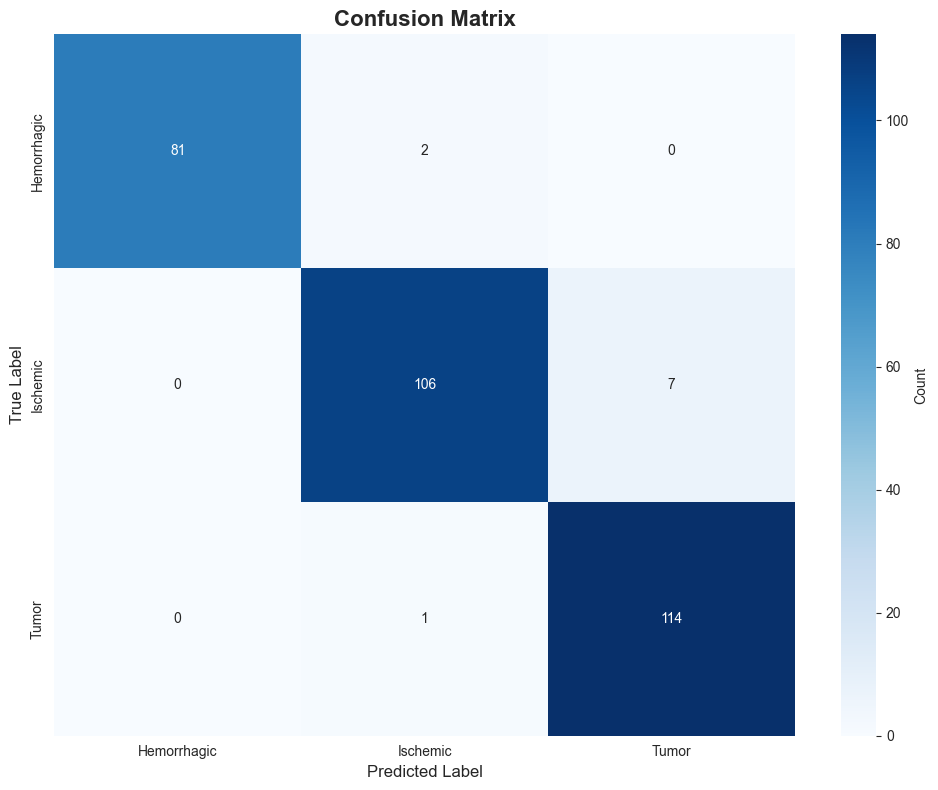

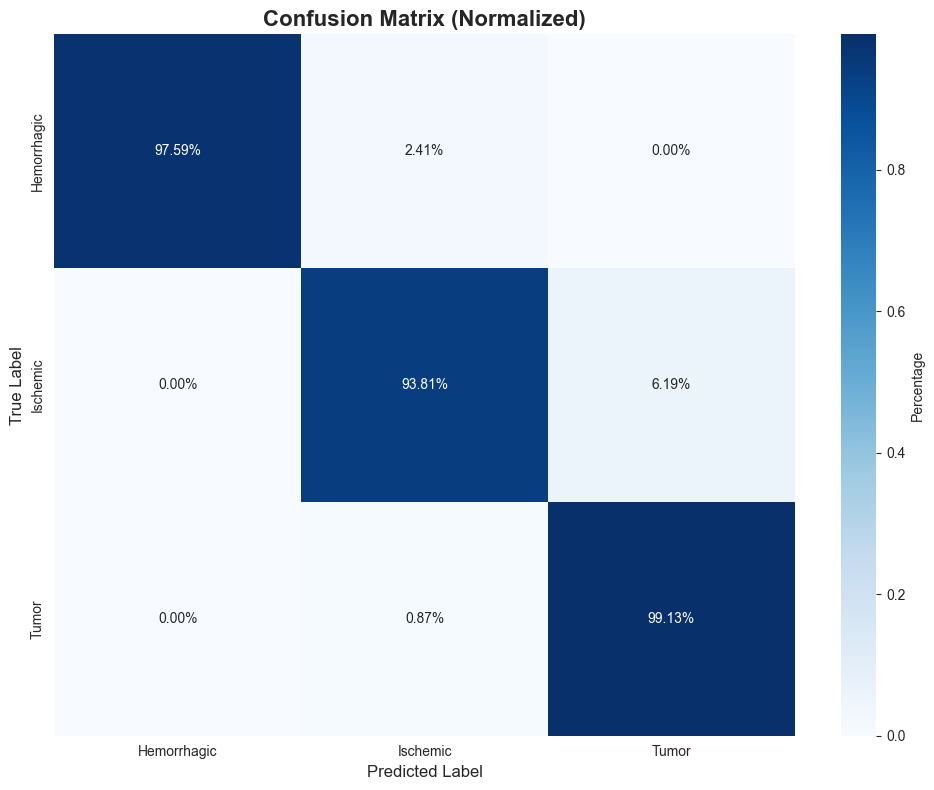

In [9]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, CLASSES)

## ROC Curves

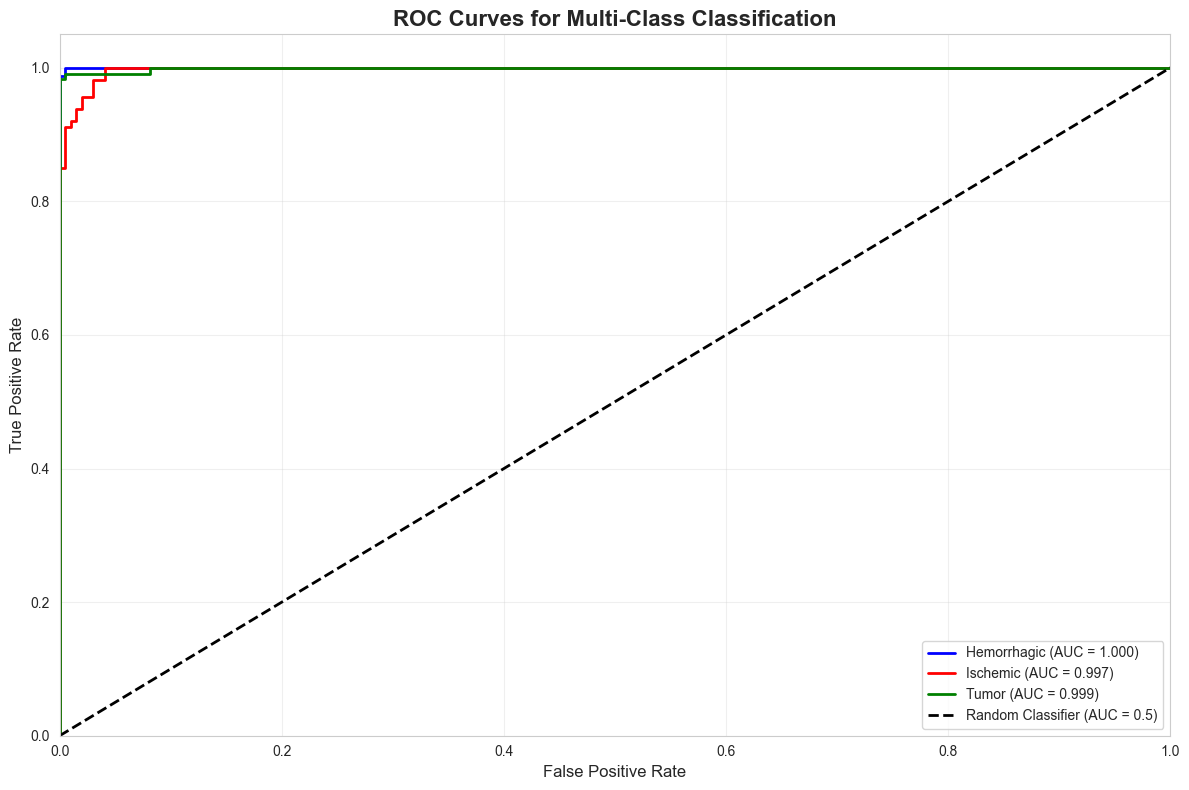


📊 ROC AUC Scores:
  Hemorrhagic: 0.9999
  Ischemic: 0.9975
  Tumor: 0.9992


In [10]:
# Plot ROC curves for all classes
plot_roc_curves(y_true, y_probs, CLASSES)

# Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) helps us visualize which regions of the brain scan the model focuses on when making predictions. This is crucial for interpretability in medical imaging.

In [11]:
import cv2
from torch.nn import functional as F

class GradCAM:
    """
    Grad-CAM implementation for ResNet50
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        """
        Generate Grad-CAM heatmap
        
        Args:
            input_image: Input tensor (1, C, H, W)
            target_class: Target class index (if None, uses predicted class)
        
        Returns:
            cam: Heatmap as numpy array
            pred_class: Predicted class index
        """
        # Forward pass
        self.model.eval()
        output = self.model(input_image)
        
        # Get predicted class if not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()
        
        # Calculate Grad-CAM
        gradients = self.gradients[0]  # (C, H, W)
        activations = self.activations[0]  # (C, H, W)
        
        # Global average pooling on gradients
        weights = gradients.mean(dim=(1, 2), keepdim=True)  # (C, 1, 1)
        
        # Weighted combination of activation maps
        cam = (weights * activations).sum(dim=0)  # (H, W)
        
        # Apply ReLU to focus on positive influence
        cam = F.relu(cam)
        
        # Normalize to [0, 1]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy(), target_class
    
    def __del__(self):
        # Clean up hooks if needed
        pass

print("✅ GradCAM class defined")

✅ GradCAM class defined


In [12]:
def visualize_gradcam(image_path, model, gradcam, save_path=None):
    """
    Visualize Grad-CAM overlay on the original image
    
    Args:
        image_path: Path to the image file
        model: Trained model
        gradcam: GradCAM instance
        save_path: Optional path to save the visualization
    """
    # Load and preprocess image
    original_image = Image.open(image_path).convert("RGB")
    original_array = np.array(original_image)
    
    # Prepare for model
    transform = transforms.Compose([
        transforms.Resize(TARGET_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(original_image).unsqueeze(0).to(DEVICE)
    
    # Generate CAM
    cam, pred_class = gradcam.generate_cam(input_tensor)
    
    # Resize CAM to match original image size
    cam_resized = cv2.resize(cam, (original_array.shape[1], original_array.shape[0]))
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Overlay heatmap on original image
    overlay = heatmap * 0.4 + original_array * 0.6
    overlay = np.uint8(overlay)
    
    # Get prediction probabilities
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)[0]
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original image
    axes[0].imshow(original_array)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay\nPredicted: {CLASSES[pred_class]}', 
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # Prediction probabilities
    axes[3].barh(CLASSES, probs.cpu().numpy(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[3].set_xlabel('Probability', fontsize=11)
    axes[3].set_title('Class Probabilities', fontsize=12, fontweight='bold')
    axes[3].set_xlim([0, 1])
    for i, prob in enumerate(probs.cpu().numpy()):
        axes[3].text(prob + 0.02, i, f'{prob:.3f}', va='center')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Saved to {save_path}")
    
    plt.show()
    
    return pred_class, probs.cpu().numpy()

print("✅ Visualization function defined")

✅ Visualization function defined


## Initialize Grad-CAM

Let's set up Grad-CAM for the last convolutional layer of ResNet50 (layer4).

In [13]:
# Load the trained model
print("🔄 Loading model for Grad-CAM...")
model = get_model()
model.load_state_dict(torch.load(MODEL_TO_EVALUATE, map_location=DEVICE))
model.eval()

# Initialize Grad-CAM with the last convolutional layer (layer4 in ResNet50)
target_layer = model.layer4[-1]  # Last bottleneck block in layer4
gradcam = GradCAM(model, target_layer)

print("✅ Grad-CAM initialized successfully!")

🔄 Loading model for Grad-CAM...


d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Grad-CAM initialized successfully!


## Visualize Sample Images

Let's visualize Grad-CAM for sample images from each class.

In [14]:
# Get sample images from each class
sample_images = {}

for cls in CLASSES:
    cls_dir = os.path.join(PROCESSED_DATA_DIR, cls)
    if os.path.exists(cls_dir):
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if files:
            # Get first image as sample
            sample_images[cls] = os.path.join(cls_dir, files[0])

print("📷 Sample images found:")
for cls, path in sample_images.items():
    print(f"  {cls}: {os.path.basename(path)}")

📷 Sample images found:
  Hemorrhagic: Kuppusamy_DWI-4.jpg_Haemorrhagic_1.png
  Ischemic: 86.jpg
  Tumor: image(1).jpg



🎨 Generating Grad-CAM visualizations...


Class: Hemorrhagic


d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


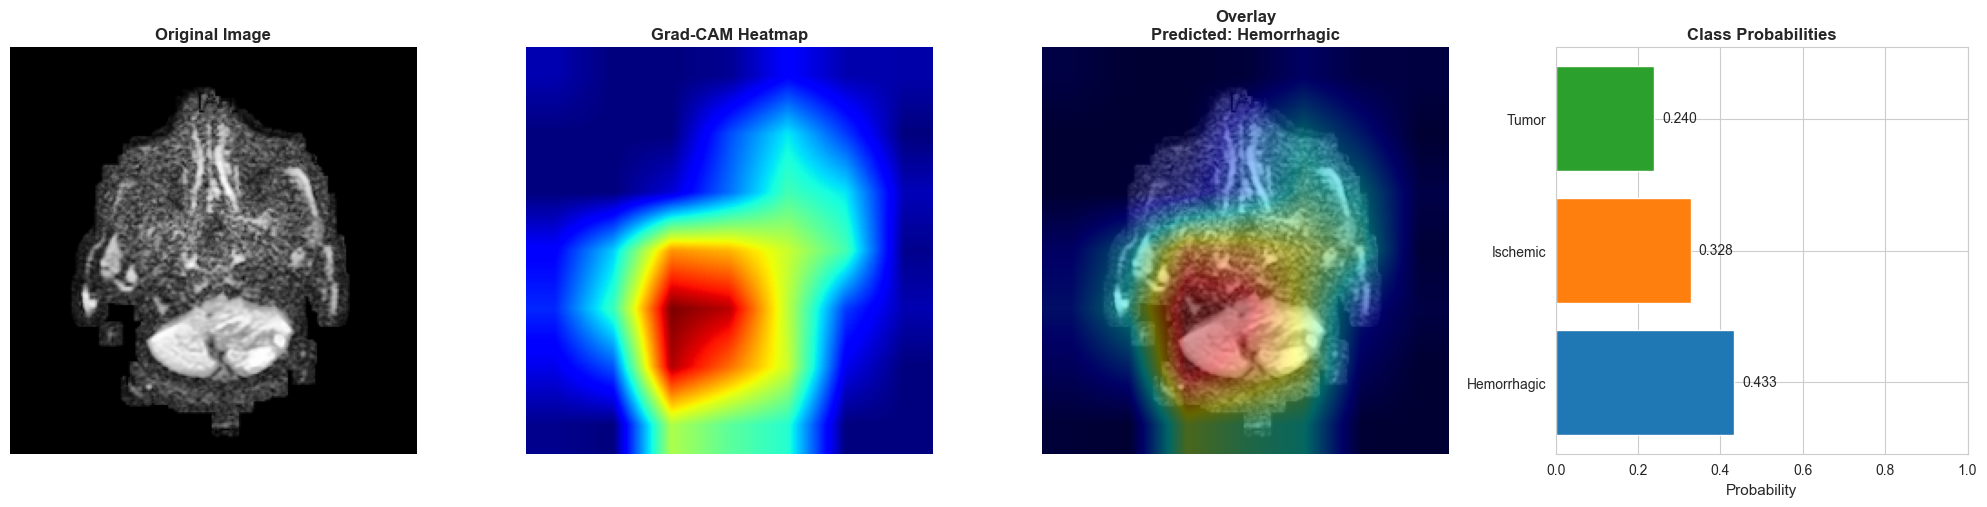

True Class: Hemorrhagic
Predicted: Hemorrhagic
Confidence: 43.27%

Class: Ischemic


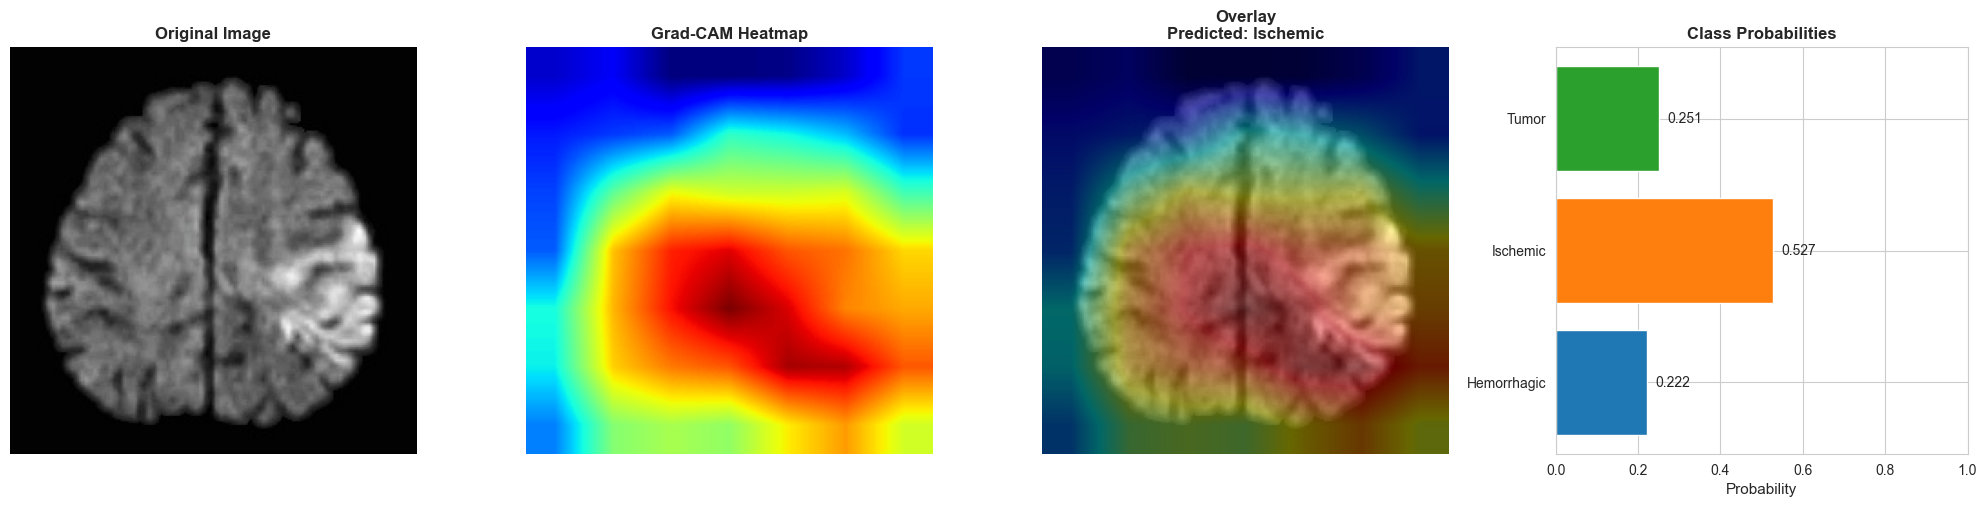

True Class: Ischemic
Predicted: Ischemic
Confidence: 52.72%

Class: Tumor


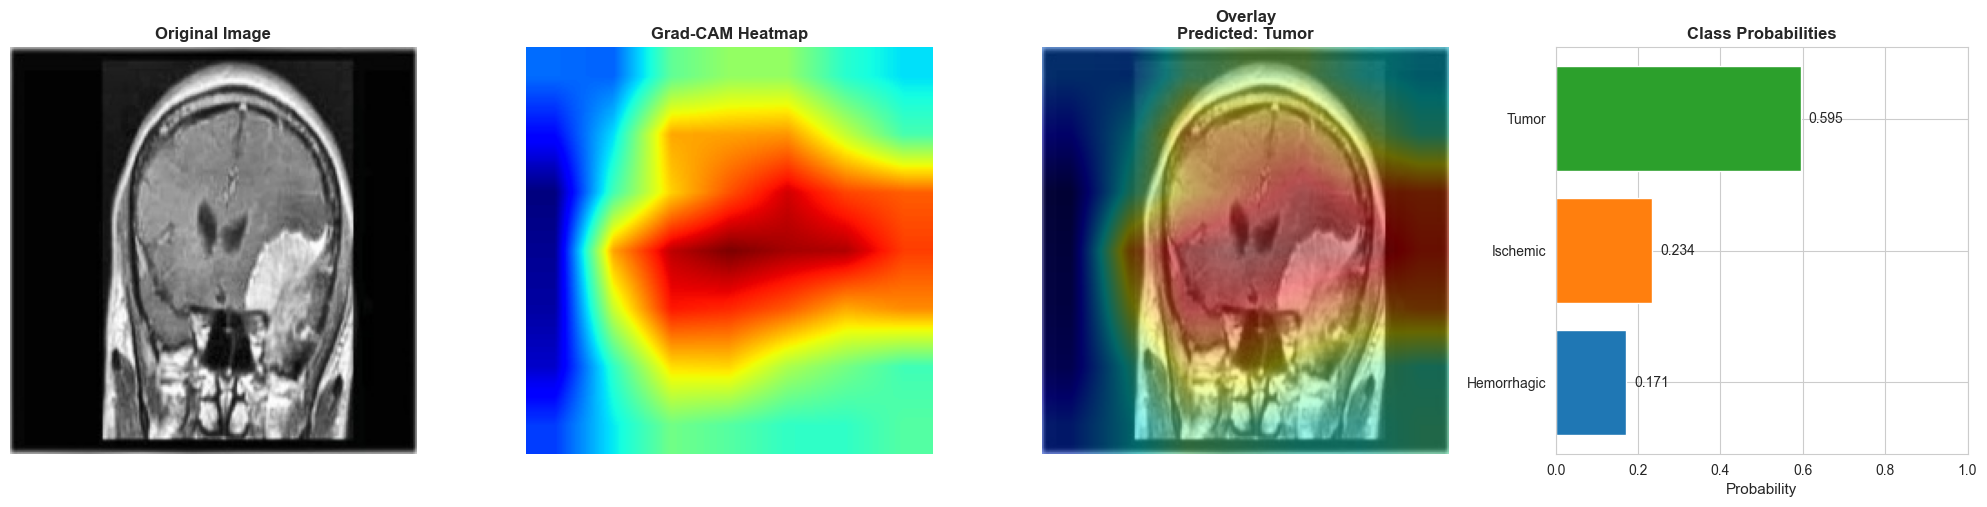

True Class: Tumor
Predicted: Tumor
Confidence: 59.47%


In [15]:
# Visualize Grad-CAM for each class
print("\n🎨 Generating Grad-CAM visualizations...\n")

for cls, img_path in sample_images.items():
    print(f"\n{'='*60}")
    print(f"Class: {cls}")
    print(f"{'='*60}")
    pred_class, probs = visualize_gradcam(img_path, model, gradcam)
    print(f"True Class: {cls}")
    print(f"Predicted: {CLASSES[pred_class]}")
    print(f"Confidence: {probs[pred_class]:.2%}")

## Custom Image Analysis

You can also analyze any specific image by providing its path.

d:\Gam3a\Senior2\Neuroengineer\project\Stroke-Tumor-Classification\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


💾 Saved to gradcam_output.png


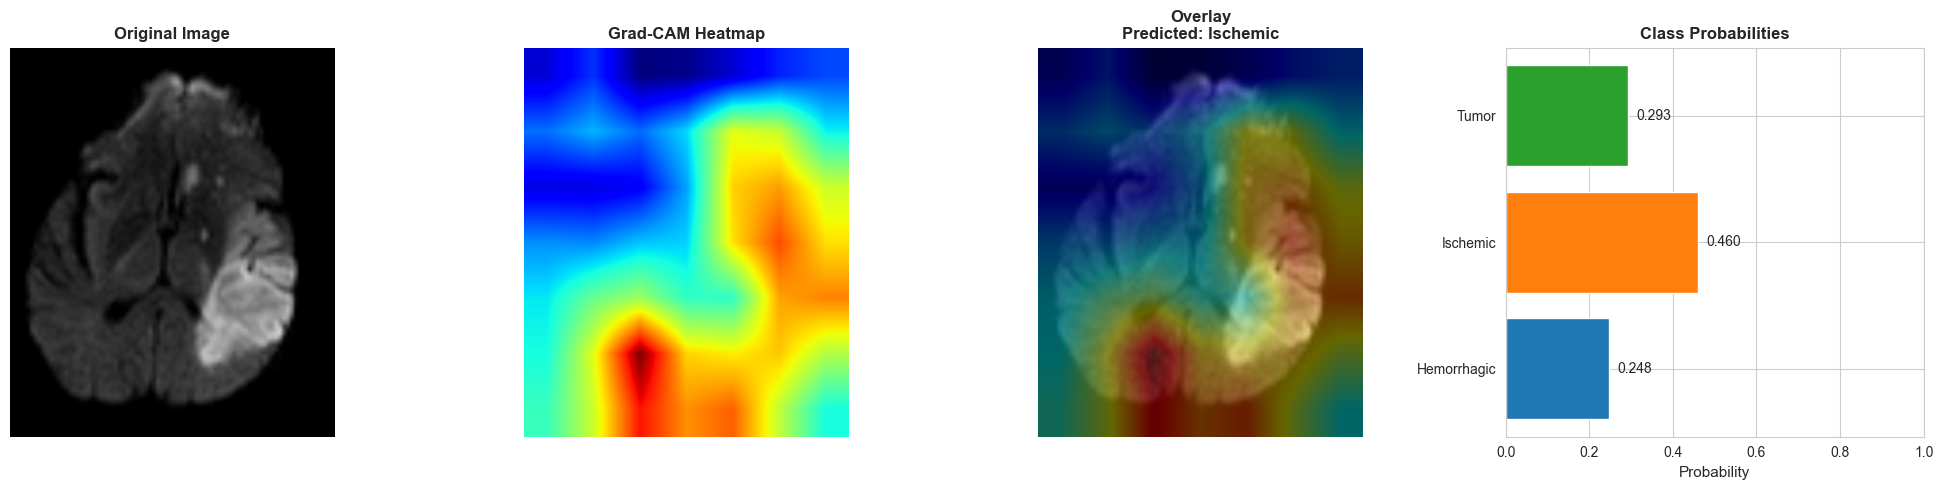

💡 To analyze a custom image, uncomment the lines above and set the correct path.


In [19]:
# Analyze a specific image (modify the path as needed)
# Example: Uncomment and modify the path below
custom_image_path = "./862.jpg"
visualize_gradcam(custom_image_path, model, gradcam, save_path="gradcam_output.png")

print("💡 To analyze a custom image, uncomment the lines above and set the correct path.")